---
<a href="https://colab.research.google.com/github/hc2x/civl7740/blob/main/tutorial-mlr-pcr-forecast.ipynb" target="_blank">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/>
</a>

# Instruction for Google Colab environment
- In order to make edits to this notebook, you should press File > "Save a Copy in Drive". This will ensure that any edits will be on your local copy, and they will not affect the notebook shared with everyone else.
- Click "Connect" on the top-right corner. Once you see RAM and Disk, you are ready to run the codes!
---

# Practice of Principal Component Regression
Prepared by Donghoon Lee (Donghoon.Lee@umanitoba.ca)

In this tutorial, we will explore
- Linear Correlation
- Covariance and Correlation Matrix
- Multiple Linear Regression
- Principal Component Analysis
- Principal Component Regression
- Cross-Validation
- Forecast Verification

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

## Sample data
We use the Diabetes data. Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

See more details about the data at [here](https://scikit-learn.org/1.5/datasets/toy_dataset.html#diabetes-dataset:~:text=7.1.2.%20Diabetes%20dataset,-%23).

In [2]:
# Loading example dataset (you would replace this with your own data)
# Assuming 'X' is a (442x10) matrix, and 'y' is a (442x1) vector.
# Here, X and y should be replaced with actual data.
from sklearn.datasets import load_diabetes
data = load_diabetes()
X = data.data     # Variables/features
y = data.target   # Target variable
print(X.shape)
print(y.shape)

(442, 10)
(442,)


### Pearson Correlation with Standardized Variables

If we have two variables $X = [x_1, x_2, \dots, x_n]$ and $Y = [y_1, y_2, \dots, y_n]$,  
the Pearson correlation coefficient is defined as:

$$
r = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}
{\sqrt{\sum (x_i - \bar{x})^2} \sqrt{\sum (y_i - \bar{y})^2}}
$$

Now, define the **standardized variables**:

$$
Z_X = \frac{X - \bar{X}}{s_X}, \quad
Z_Y = \frac{Y - \bar{Y}}{s_Y}
$$

Then the correlation can be written simply as:

$$
r = \frac{1}{n-1} \sum_{i=1}^{n} Z_{X_i} Z_{Y_i}
$$

with covariance:

$$
r = \frac{\text{COV}(X, Y)}{s_X s_Y}
$$

where:
- $\text{COV}(X, Y) = \frac{\sum (x_i - \mu_X)(y_i - \mu_Y)}{\text{DOF}}$
- $s_X$, $s_Y$ are the standard deviations of X and Y
- DOF = degrees of freedom (typically $n - 1$)

**Interpretation:**  
If both variables are standardized (mean 0, standard deviation 1),  
the Pearson correlation is just the **average of the product of standardized scores**.

---

### Linear Correlation (Conceptually)

- **Linear correlation** measures how strongly two variables are linearly related.  
- It only captures **straight-line relationships**, not nonlinear patterns.
- $r > 0$: as X increases, Y tends to increase.  
- $r < 0$: as X increases, Y tends to decrease.  
- $r = 0$: no linear relationship (but nonlinear may still exist).

The strength of the linear association is determined by $|r|$.

---

### Relationship Between Correlation and Regression Slope

For a simple linear regression:

$$
Y = \beta_0 + \beta_1 X + \epsilon
$$

The estimated slope $\hat{\beta}_1$ is related to the correlation $r$ by:

$$
\hat{\beta}_1 = r \cdot \frac{s_Y}{s_X}
$$

where:
- $s_X$, $s_Y$ are the standard deviations of X and Y.
- $r$ is the Pearson correlation coefficient.

Thus:
- The **sign of the slope** is the same as the **sign of the correlation**.
- The **magnitude of the slope** depends on both the correlation strength and the ratio of standard deviations.

---

### Summary

| Concept | Formula | Key Idea |
|----------|----------|----------|
| Correlation (standardized form) | $r = \frac{1}{n-1} \sum Z_X Z_Y$ | Mean product of standardized scores |
| Regression slope | $\hat{\beta}_1 = r \cdot \frac{s_Y}{s_X}$ | Scaled version of correlation |
| Interpretation | $r \in [-1, 1]$ | Measures linear strength & direction |

---

**In short:**  
> Correlation is the *standardized form of covariance*,  
> and regression slope is a *scaled version of correlation*.

## Correlation Analysis and Regression

### Regression Relationship

For the **simple linear regression model**:

$$
Y = a + bX
$$

The **slope** $b$ and **intercept** $a$ are related to the correlation as follows:

#### Slope of the Regression Line:

$$
b = \frac{\text{COV}(X, Y)}{\text{VAR}(X)} = r \cdot \frac{s_Y}{s_X}
$$

#### Intercept:
$$
a = \bar{Y} - b \bar{X}
$$

---

### Relationship Between Correlation and Slope

You can rearrange the relationship between the slope and correlation:

$$
\begin{aligned}
\text{Slope} \times \text{Ratio}(s_X / s_Y) &= r \\
r \times \text{Ratio}(s_Y / s_X) &= \text{Slope}
\end{aligned}
$$

---

### Summary

| Concept | Formula | Description |
|----------|----------|-------------|
| Covariance | $\text{COV}(X, Y) = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{n - 1}$ | Measures joint variability |
| Pearson’s r | $r = \frac{\text{COV}(X, Y)}{s_X s_Y}$ | Standardized covariance |
| Regression slope | $b = r \cdot \frac{s_Y}{s_X}$ | Scaled by std ratio |
| Regression intercept | $a = \bar{Y} - b \bar{X}$ | Line offset |
| Relation | $r = b \cdot \frac{s_X}{s_Y}$ | Correlation–slope link |

---

**In short:**  
> - Correlation ($r$) is a standardized measure of linear relationship.  
> - Regression slope ($b$) is a scaled version of correlation, depending on the variability ratio of X and Y.

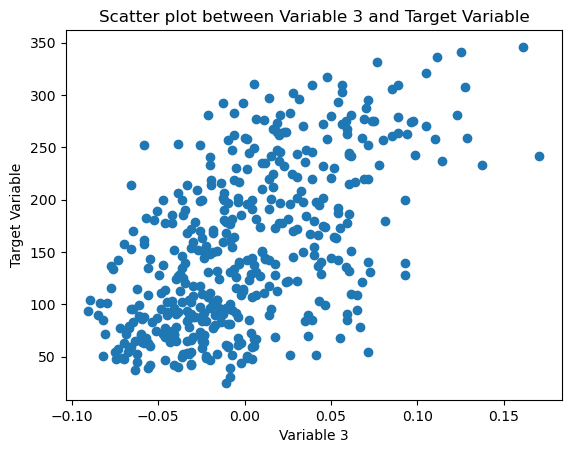

In [3]:
x = X[:, 2] # Variable 3
# Scatter plot
import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.xlabel('Variable 3')
plt.ylabel('Target Variable')
plt.title('Scatter plot between Variable 3 and Target Variable')
plt.show()

In [4]:
# Correlation using raw equation
x_mean = np.mean(x)
y_mean = np.mean(y)
numerator = np.sum((x - x_mean) * (y - y_mean))
denominator = np.sqrt(np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2))
r_manual = numerator / denominator
print("R (manual):", r_manual)
# Correlation with standardized variables
x_std = (x - np.mean(x)) / np.std(x, ddof=1)
y_std = (y - np.mean(y)) / np.std(y, ddof=1)
r_std = np.mean(x_std * y_std)
print("R (standardized):", r_std)
# Correlation using numpy
r_numpy = np.corrcoef(x, y)[0, 1]
print("R (numpy):", r_numpy)

R (manual): 0.5864501344746886
R (standardized): 0.585123324215696
R (numpy): 0.5864501344746887


In [5]:
# Simple Linear Regression
from sklearn.linear_model import LinearRegression
x_reshaped = x.reshape(-1, 1)  # Reshape for sklearn
model = LinearRegression()
model.fit(x_reshaped, y)
slope = model.coef_[0]
intercept = model.intercept_
print("Slope:", slope)
print("Intercept:", intercept)
# Verify slope and intercept with correlation
s_y = np.std(y, ddof=1)
s_x = np.std(x, ddof=1)
r = r_numpy
slope_check = r * (s_y / s_x)
intercept_check = np.mean(y) - slope_check * np.mean(x)
print("Slope check:", slope_check)
print("Intercept check:", intercept_check)

Slope: 949.4352603840372
Intercept: 152.13348416289617
Slope check: 949.4352603840388
Intercept check: 152.13348416289617


R²: 0.3439237602253802


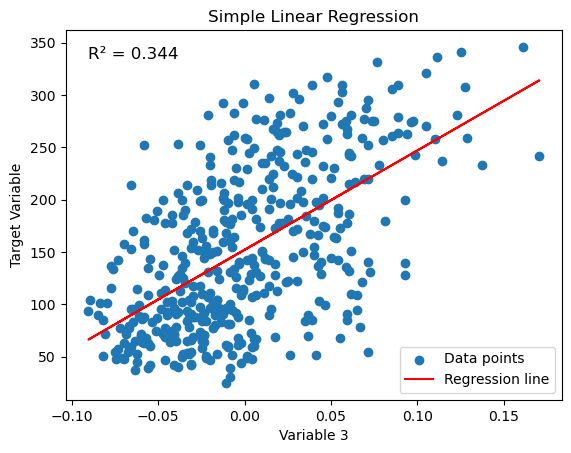

In [6]:
# Scatter plot with regression line
plt.scatter(x, y, label='Data points')
plt.plot(x, model.predict(x_reshaped), color='red', label='Regression line')
plt.xlabel('Variable 3')
plt.ylabel('Target Variable')
plt.title('Simple Linear Regression')
# R2 calculation
y_pred = model.predict(x_reshaped)
r2 = r2_score(y, y_pred)
print("R²:", r2)
# Annotate R² on the plot
plt.text(min(x), max(y), f'R² = {r2:.3f}', fontsize=12, verticalalignment='top')
plt.legend()
plt.show()

## Covariance matrix and Correlation matrix

Suppose we have a data matrix **X** containing $n$ observations and $p$ variables:

$$
\mathbf{X} =
\begin{bmatrix}
x_{11} & x_{12} & \dots & x_{1p} \\
x_{21} & x_{22} & \dots & x_{2p} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \dots & x_{np}
\end{bmatrix}
$$

---

### Centering the Data

Compute the mean of each variable (column):

$$
\bar{x}_j = \frac{1}{n} \sum_{i=1}^{n} x_{ij}
$$

Then create a **mean-centered matrix** $\mathbf{X}_c$:

$$
\mathbf{X}_c = \mathbf{X} - \mathbf{1}_n \bar{\mathbf{x}}^T
$$

where:
- $\mathbf{1}_n$ is an $n \times 1$ column vector of ones  
- $\bar{\mathbf{x}} = [\bar{x}_1, \bar{x}_2, \dots, \bar{x}_p]^T$

---

### Covariance Matrix

The **sample covariance matrix** $\mathbf{\Sigma}$ (size $p \times p$) is given by:

$$
\mathbf{\Sigma} = \frac{1}{n - 1} \mathbf{X}_c^T \mathbf{X}_c
$$

Expanded element-wise, each entry represents:

$$
\Sigma_{jk} = \frac{1}{n - 1} \sum_{i=1}^{n} (x_{ij} - \bar{x}_j)(x_{ik} - \bar{x}_k)
$$

- $\Sigma_{jj}$ → variance of variable $j$  
- $\Sigma_{jk}$ → covariance between variables $j$ and $k$

---

### Standardization (to Compute Correlation)

Compute the **standard deviation vector**:

$$
\mathbf{s} = [s_1, s_2, \dots, s_p], \quad
s_j = \sqrt{\Sigma_{jj}}
$$

Construct a **diagonal scaling matrix** $\mathbf{D}_s$:

$$
\mathbf{D}_s = \text{diag}(s_1, s_2, \dots, s_p)
$$

Then the **correlation matrix** $\mathbf{R}$ is obtained by normalizing the covariance matrix:

$$
\mathbf{R} = \mathbf{D}_s^{-1} \, \mathbf{\Sigma} \, \mathbf{D}_s^{-1}
$$

or element-wise:

$$
R_{jk} = \frac{\Sigma_{jk}}{s_j s_k}
$$

---

### Summary Table

| Concept | Symbol | Formula |
|----------|----------|----------|
| Centered matrix | $\mathbf{X}_c$ | $\mathbf{X}_c = \mathbf{X} - \mathbf{1}_n \bar{\mathbf{x}}^T$ |
| Covariance matrix | $\mathbf{\Sigma}$ | $\mathbf{\Sigma} = \frac{1}{n-1}\mathbf{X}_c^T\mathbf{X}_c$ |
| Std. deviation matrix | $\mathbf{D}_s$ | $\mathbf{D}_s = \text{diag}(\sqrt{\Sigma_{11}}, \dots, \sqrt{\Sigma_{pp}})$ |
| Correlation matrix | $\mathbf{R}$ | $\mathbf{R} = \mathbf{D}_s^{-1}\mathbf{\Sigma}\mathbf{D}_s^{-1}$ |

---

### 💡 Intuition

- Covariance matrix shows **how much variables vary together** (scale-dependent).  
- Correlation matrix standardizes it, showing **pure strength of linear relationships**, independent of units.

In [7]:
# Center the data matrix X
X_mean = np.mean(X, axis=0)
X_centered = X - X_mean
# Covariance matrix
n_samples = X.shape[0]
cov_matrix = (X_centered.T @ X_centered) / (n_samples - 1)
print("Covariance Matrix:\n", cov_matrix.round(3))
# Standard deviation vector
std_vector = np.std(X, axis=0, ddof=1)
# Correlation matrix
corr_matrix = cov_matrix / np.outer(std_vector, std_vector)
print("Correlation Matrix:\n", corr_matrix.round(3)) 

Covariance Matrix:
 [[ 0.002  0.     0.     0.001  0.001  0.    -0.     0.     0.001  0.001]
 [ 0.     0.002  0.     0.001  0.     0.    -0.001  0.001  0.     0.   ]
 [ 0.     0.     0.002  0.001  0.001  0.001 -0.001  0.001  0.001  0.001]
 [ 0.001  0.001  0.001  0.002  0.001  0.    -0.     0.001  0.001  0.001]
 [ 0.001  0.     0.001  0.001  0.002  0.002  0.     0.001  0.001  0.001]
 [ 0.     0.     0.001  0.     0.002  0.002 -0.     0.001  0.001  0.001]
 [-0.    -0.001 -0.001 -0.     0.    -0.     0.002 -0.002 -0.001 -0.001]
 [ 0.     0.001  0.001  0.001  0.001  0.001 -0.002  0.002  0.001  0.001]
 [ 0.001  0.     0.001  0.001  0.001  0.001 -0.001  0.001  0.002  0.001]
 [ 0.001  0.     0.001  0.001  0.001  0.001 -0.001  0.001  0.001  0.002]]
Correlation Matrix:
 [[ 1.     0.174  0.185  0.335  0.26   0.219 -0.075  0.204  0.271  0.302]
 [ 0.174  1.     0.088  0.241  0.035  0.143 -0.379  0.332  0.15   0.208]
 [ 0.185  0.088  1.     0.395  0.25   0.261 -0.367  0.414  0.446  0.389]
 [ 0.335 

In [8]:
print('Covariance matrix')
cov_matrix = np.cov(X, rowvar=False)
print(cov_matrix.round(3))
print()
print('Correlation matrix')
corr_matrix = np.corrcoef(X, rowvar=False)
print(corr_matrix.round(3))

Covariance matrix
[[ 0.002  0.     0.     0.001  0.001  0.    -0.     0.     0.001  0.001]
 [ 0.     0.002  0.     0.001  0.     0.    -0.001  0.001  0.     0.   ]
 [ 0.     0.     0.002  0.001  0.001  0.001 -0.001  0.001  0.001  0.001]
 [ 0.001  0.001  0.001  0.002  0.001  0.    -0.     0.001  0.001  0.001]
 [ 0.001  0.     0.001  0.001  0.002  0.002  0.     0.001  0.001  0.001]
 [ 0.     0.     0.001  0.     0.002  0.002 -0.     0.001  0.001  0.001]
 [-0.    -0.001 -0.001 -0.     0.    -0.     0.002 -0.002 -0.001 -0.001]
 [ 0.     0.001  0.001  0.001  0.001  0.001 -0.002  0.002  0.001  0.001]
 [ 0.001  0.     0.001  0.001  0.001  0.001 -0.001  0.001  0.002  0.001]
 [ 0.001  0.     0.001  0.001  0.001  0.001 -0.001  0.001  0.001  0.002]]

Correlation matrix
[[ 1.     0.174  0.185  0.335  0.26   0.219 -0.075  0.204  0.271  0.302]
 [ 0.174  1.     0.088  0.241  0.035  0.143 -0.379  0.332  0.15   0.208]
 [ 0.185  0.088  1.     0.395  0.25   0.261 -0.367  0.414  0.446  0.389]
 [ 0.335  0.

## Data normalization

Normalization (or standardization) transforms the data so that it has a mean of 0 and a standard deviation of 1. This is expressed as:

> $$
X_{standardized} = \frac{X - \mu_X}{\sigma_X}
$$

Question: Is it better to apply normalization before PCA? Why? How about the dataset we are using?


<!-- Answer:

Yes, it is generally better to apply normalization before performing Principal Component Analysis (PCA). The reason is that PCA is sensitive to the scale of the variables. If the features in the dataset have different units or scales, variables with larger ranges can dominate the principal components, leading to misleading results. Normalization ensures that each feature contributes equally to the analysis, making PCA more effective in identifying the true patterns in the data.

For the dataset we are using (diabetes data), normalization is essential because the features (such as age, BMI, blood pressure, etc.) may have different ranges. By standardizing the data, we ensure that each principal component captures meaningful variations across all features. -->


In [9]:
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

In [10]:
print('Covariance matrix')
cov_matrix = np.cov(X, rowvar=False)
print(cov_matrix.round(3))

Covariance matrix
[[ 1.002  0.174  0.186  0.336  0.261  0.22  -0.075  0.204  0.271  0.302]
 [ 0.174  1.002  0.088  0.242  0.035  0.143 -0.38   0.333  0.15   0.209]
 [ 0.186  0.088  1.002  0.396  0.25   0.262 -0.368  0.415  0.447  0.39 ]
 [ 0.336  0.242  0.396  1.002  0.243  0.186 -0.179  0.258  0.394  0.391]
 [ 0.261  0.035  0.25   0.243  1.002  0.899  0.052  0.543  0.517  0.326]
 [ 0.22   0.143  0.262  0.186  0.899  1.002 -0.197  0.661  0.319  0.291]
 [-0.075 -0.38  -0.368 -0.179  0.052 -0.197  1.002 -0.74  -0.399 -0.274]
 [ 0.204  0.333  0.415  0.258  0.543  0.661 -0.74   1.002  0.619  0.418]
 [ 0.271  0.15   0.447  0.394  0.517  0.319 -0.399  0.619  1.002  0.466]
 [ 0.302  0.209  0.39   0.391  0.326  0.291 -0.274  0.418  0.466  1.002]]


## Multiple Linear Regression model

The MLR is expressed as

> $$
y = X\beta + \epsilon, \quad (1)
$$

where $y$ is a vector of $n$ observations on the dependent variable, measured about their mean, $X$ is an ($n \times p$) matrix whose ($i, j$) th element is the value of the $j$ th predictor (or regressor) variable for the ith observation, again measured about its mean, $\beta$ is a vector of $p$ regression coefficients and $\epsilon$ is a vector of error terms.

In [11]:
# Initialize and train the Multiple Linear Regression model
mlr_model = LinearRegression()
mlr_model.fit(X, y)
beta = mlr_model.coef_
print(beta.round(3))
y_hat_mlr = mlr_model.predict(X)

[ -0.476 -11.407  24.727  15.429 -37.68   22.676   4.806   8.422  35.734
   3.217]


correlation:	 0.72
r-squared:	 0.518


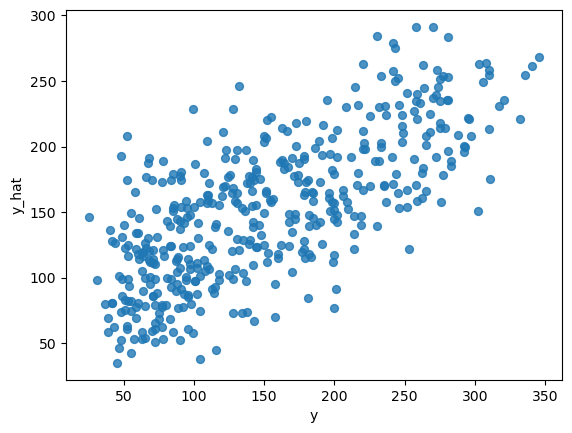

In [12]:
df = pd.DataFrame({'y': y, 'y_hat': y_hat_mlr})
df.plot(x='y', y='y_hat', kind='scatter', s=32, alpha=.8)
print('correlation:\t', np.round(df.corr().values[0, 1], 3))
print('r-squared:\t', np.round(r2_score(y, y_hat_mlr),3))

## Principal Component Analysis (PCA)

The value of the PCs for each observation are given by

> $$
Z = XA, \quad (2)
$$

where the ($i, k$) th element of $Z$ is the value (score) of the $k$ th PC for the $i$ th observation, and $A$ is a ($p \times p$) matrix whose $k$ th column is the $k$ th eigenvector of $X'X$.


In [13]:
pca = PCA(n_components=X.shape[1])
Z = pca.fit_transform(X)  # Z is PC matrix (n x p)
A = pca.components_       # A is Eigenvector (p x p)
print(pca.components_.shape)
print(Z.shape)

(10, 10)
(442, 10)


Check the variance explained by each principal component (PC). Accumulate these values to determine the number of PCs you would like to retain.

Hint: 80%

In [14]:
var_explained = pca.explained_variance_ratio_ # Eigenvalues
print('Variance explained')
print(var_explained.round(3))
print('Cumulative variance explained')
print(np.cumsum(var_explained).round(3))

Variance explained
[0.402 0.149 0.121 0.096 0.066 0.06  0.054 0.043 0.008 0.001]
Cumulative variance explained
[0.402 0.552 0.672 0.768 0.834 0.894 0.948 0.991 0.999 1.   ]


In [15]:
# Is correlation matrix used for PCA analysis?
print(pca.get_covariance().round(3))

[[ 1.002  0.174  0.186  0.336  0.261  0.22  -0.075  0.204  0.271  0.302]
 [ 0.174  1.002  0.088  0.242  0.035  0.143 -0.38   0.333  0.15   0.209]
 [ 0.186  0.088  1.002  0.396  0.25   0.262 -0.368  0.415  0.447  0.39 ]
 [ 0.336  0.242  0.396  1.002  0.243  0.186 -0.179  0.258  0.394  0.391]
 [ 0.261  0.035  0.25   0.243  1.002  0.899  0.052  0.543  0.517  0.326]
 [ 0.22   0.143  0.262  0.186  0.899  1.002 -0.197  0.661  0.319  0.291]
 [-0.075 -0.38  -0.368 -0.179  0.052 -0.197  1.002 -0.74  -0.399 -0.274]
 [ 0.204  0.333  0.415  0.258  0.543  0.661 -0.74   1.002  0.619  0.418]
 [ 0.271  0.15   0.447  0.394  0.517  0.319 -0.399  0.619  1.002  0.466]
 [ 0.302  0.209  0.39   0.391  0.326  0.291 -0.274  0.418  0.466  1.002]]


## PCR Model 1: Using principal components as predictors

Because $A$ is orthogonal, $X\beta$ can be rewritten as $XAA'\beta = Z\gamma$, where $\gamma=A'\beta$. The MLR equation can therefore be written as:

> $$
y = Z\gamma + \epsilon \quad (3)
$$

which has simply replaced the predictor variables by their principal components (PCs) in the regression model. Principal component regression (PCR) can be defined as the use of the model or of the reduced model:


> $$
y = Z_m\gamma_m + \epsilon_m, \quad (4)
$$

where $\gamma_m$ is a vector of $m$ elements that are a subset of elements of $\gamma$, $Z_m$ is an $n \times m$ matrix whose columns are the corresponding subset of columns of $Z$, and $\epsilon_m$ is the appropriate error term.

When you fit a PCR model on the standardized $X$, the predictions  $\hat{y}$ you get are based on this centered version of $y$. Therefore, the predicted $\hat{y}$ values are also mean-centered and will not reflect the original scale of $y$.



In [16]:
npc = 5  # number of retained PCs
gamma = LinearRegression().fit(Z[:, :npc], y).coef_
print(gamma.round(3))
y_hat_pcr1 = Z[:, :npc].dot(gamma)
y_hat_pcr1 = y_hat_pcr1 + y.mean()
print('r-squared:\t', np.round(r2_score(y, y_hat_pcr1),3))

[ 21.318 -12.212  11.332 -28.211   0.794]
r-squared:	 0.5


## PCR Model 2: Using original features as predictors

Using least squares to estimate $\gamma$ in (3) and then finding an estimate for $\beta$ from the equation:

> $$
\beta = A\gamma \quad (5)
$$

is equivalent to finding $\beta$ by applying least squares directly to (1).

In [17]:
beta = pca.components_[:npc, :].T.dot(gamma)  # Transform gamma to beta
print(beta.round(3))
y_hat_pcr2 = X.dot(beta)
y_hat_pcr2 = y_hat_pcr2 + y.mean()
print('r-squared:\t', np.round(r2_score(y, y_hat_pcr1),3))
print(f'Corr(PCR1, PCR2): {np.corrcoef(y_hat_pcr1, y_hat_pcr2)[0, 1]:.3f}')  # This should be 1
print(f'Corr(MLR, PCR2): {np.corrcoef(y_hat_mlr, y_hat_pcr2)[0,1]:.3f}')

[ -1.457 -11.98   24.268  12.36   -2.489  -5.949 -10.168   5.998  16.692
  13.475]
r-squared:	 0.5
Corr(PCR1, PCR2): 1.000
Corr(MLR, PCR2): 0.983


Adjust the number of retained principal components (npc) to match the number of predictors, and then re-run the two cells above.



## Practice 1: PCR forecasting with train/test data
We split the data 70% for training and 30% for testing.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)

# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (309, 10)
y_train shape: (309,)
X_test shape: (133, 10)
y_test shape: (133,)


In [19]:
# Normalization based on X_train
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X_train)

# PCR modeling based on training data
pca = PCA(n_components=X_train.shape[1])
Z = pca.fit_transform(X_train)
print(np.cumsum(pca.explained_variance_ratio_.round(3)))
npc = 5 # Adjust npc
gamma = LinearRegression().fit(Z[:, :npc], y_train).coef_
beta = pca.components_[:npc, :].T.dot(gamma)
print(gamma.round(3))
print(beta.round(3))
y_train_hat = X_train.dot(beta) + y_train.mean()

# PCR2 Forecast on testing data
y_test_hat = X_test.dot(beta) + y_train.mean()

# Results
print(f'Corr(yTran, yTranHat): {np.corrcoef(y_train, y_train_hat)[0, 1]:.3f}')
print(f'Corr(yTest, yTestHat): {np.corrcoef(y_test, y_test_hat)[0, 1]:.3f}')
print(f'R2(yTran, yTranHat): {r2_score(y_train, y_train_hat):.3f}')
print(f'R2(yTest, yTestHat): {r2_score(y_test, y_test_hat):.3f}')

[0.399 0.546 0.671 0.768 0.834 0.894 0.948 0.992 1.    1.001]
[ 448.998 -287.102  397.038 -488.625  -22.296]
[ -14.92  -242.884  498.89   299.629  -76.363 -137.13  -223.07   122.871
  316.208  305.863]
Corr(yTran, yTranHat): 0.708
Corr(yTest, yTestHat): 0.696
R2(yTran, yTranHat): 0.500
R2(yTest, yTestHat): 0.484


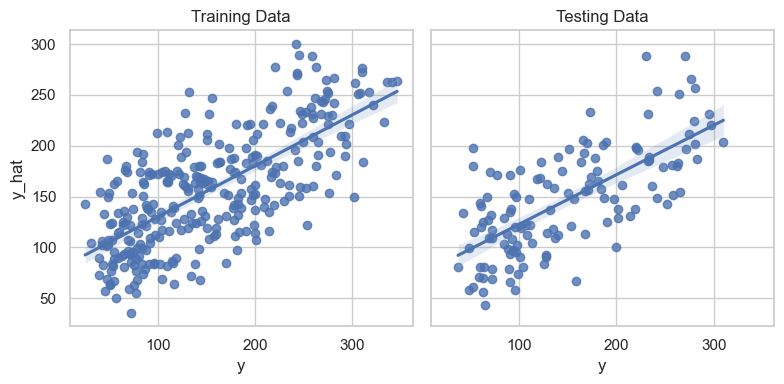

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
# Plot training data
sns.regplot(x=y_train, y=y_train_hat, ax=axes[0])
axes[0].set_title('Training Data')
axes[0].set_xlabel('y')
axes[0].set_ylabel('y_hat')
# Plot testing data
sns.regplot(x=y_test, y=y_test_hat, ax=axes[1])
axes[1].set_title('Testing Data')
axes[1].set_xlabel('y')
axes[1].set_xlim(axes[0].get_xlim())
plt.tight_layout()
plt.show()

## Practice 2: PCR forecasting with cross validation
Here we use the leave-one-out cross validation (LOOCV). Let's start with an example.

In [21]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
for train, test in loo.split(np.arange(10)):
    print(train, test)

[1 2 3 4 5 6 7 8 9] [0]
[0 2 3 4 5 6 7 8 9] [1]
[0 1 3 4 5 6 7 8 9] [2]
[0 1 2 4 5 6 7 8 9] [3]
[0 1 2 3 5 6 7 8 9] [4]
[0 1 2 3 4 6 7 8 9] [5]
[0 1 2 3 4 5 7 8 9] [6]
[0 1 2 3 4 5 6 8 9] [7]
[0 1 2 3 4 5 6 7 9] [8]
[0 1 2 3 4 5 6 7 8] [9]


There are various CV approaches (see [here](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators)).

Now let's use the sample data.

In [22]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)

# Normalization based on X
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

# PCR with LOOCV
npc = 5 # Adjust npc
loo = LeaveOneOut()
y_hat = np.full_like(y, np.nan) # empty array to store prediction values
for train, test in loo.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    pca = PCA(n_components=X_train.shape[1])
    Z = pca.fit_transform(X_train)
    gamma = LinearRegression().fit(Z[:, :npc], y_train).coef_
    beta = pca.components_[:npc, :].T.dot(gamma)
    y_hat[test] = X_test.dot(beta)
y_hat = y_hat + y.mean()
print(f'Corr(y, y_hat): {np.corrcoef(y, y_hat)[0, 1]:.3f}')
print(f'R2(y, y_hat): {r2_score(y, y_hat):.3f}')

Corr(y, y_hat): 0.699
R2(y, y_hat): 0.489


<Axes: xlabel='y', ylabel='y_hat'>

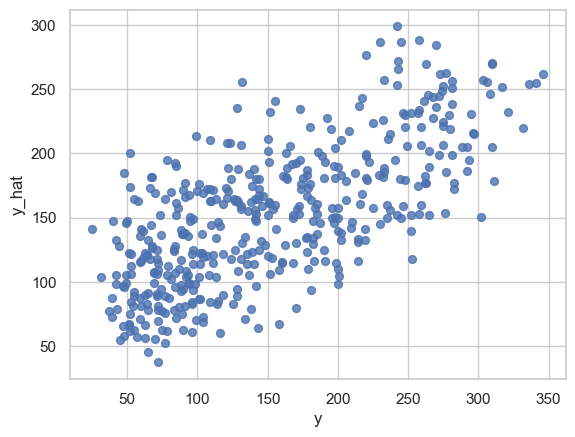

In [23]:
df= pd.DataFrame({'y': y, 'y_hat': y_hat})
df.plot(x='y', y='y_hat', kind='scatter', s=32, alpha=.8)

## Contingency table

Let’s create a 2x2 contingency table, categorizing the data into “yes” and “no” based on the average values.

In [24]:
def contingency_table_2x2(y, y_hat, threshold = None):
    if threshold is None:
        threshold = y.mean()
    table = np.zeros((2, 2))
    y_bin = np.where(y >= threshold, 1, 0)
    y_hat_bin = np.where(y_hat >= threshold, 1, 0)
    for i in range(len(y_bin)):
        if y_bin[i] == 1 and y_hat_bin[i] == 1:
            table[0, 0] += 1  # True Positive (TP)
        elif y_bin[i] == 1 and y_hat_bin[i] == 0:
            table[0, 1] += 1  # False Negative (FN)
        elif y_bin[i] == 0 and y_hat_bin[i] == 1:
            table[1, 0] += 1  # False Positive (FP)
        elif y_bin[i] == 0 and y_hat_bin[i] == 0:
            table[1, 1] += 1  # True Negative (TN)
    return table

In [25]:
table = contingency_table_2x2(y, y_hat).astype(int)
table = pd.DataFrame(table, index=['yes', 'no'], columns=['yes', 'no'])
print(table)

     yes   no
yes  144   51
no    71  176


In [26]:
a, b, c, d = table.values.flatten()
n = a + b + c + d
print(f'a (Hits) = {a}')
print(f'b (False alarms) = {b}')
print(f'c (Misses) = {c}')
print(f'd (Correct negatives) = {d}')
print(f'n (Total) = {n}')

a (Hits) = 144
b (False alarms) = 51
c (Misses) = 71
d (Correct negatives) = 176
n (Total) = 442


In [27]:
# False Alarm Ratio
far = b / (a + b)
print(f'False Alarm Ratio (FAR): {far:.3f}')

# Probability of Detection (Hit rate)
pod = a / (a + c)
print(f'Probability of Detection (POD): {pod:.3f}')

False Alarm Ratio (FAR): 0.262
Probability of Detection (POD): 0.670


Calculate the Heidke Skill Score (HSS) and the Peirce
Skill Score (PSS)

Try other categorical verification metrics. See [the WWRP's website for Verification Methods](https://www.cawcr.gov.au/projects/verification/#Methods_for_dichotomous_forecasts).